# 01. Quickstart

In [2]:
# import the hoomd, htf packages
import hoomd
import hoomd.htf as htf
import tensorflow as tf

## Build the SimModel

Here we prepare the computations that will be executed at each step during the simulation. We have access to the neighbor list, positions, types, box dimensions of the simulation. Ignore sample_weight for now. Here we define a simple 1 / r potential, save its energy, and use the auto-differentiation tool to compute forces. 

In [10]:
class MyModel(htf.SimModel):
    def compute(self, nlist, positions, box, sample_weight):
        pair_energy = htf.nlist_rinv(nlist) # nlist_rinv is neighbor 1 / r
        particle_energy = tf.reduce_sum(pair_energy, axis=1) # sum over neighbors        
        forces = htf.compute_nlist_forces(nlist, particle_energy)
        sys_energy = tf.reduce_sum(particle_energy) # output system energy
        return forces, sys_energy

## Running the simulation

Now we run the simulation using the usual hoomd-blue syntax. We can specify things like how often the model is called, how often it is saved, etc. in the `attach` command. This simulation is 144 particles in 2D, whose forces are the ones we defined above. 

In [13]:
########### Hoomd-Sim Code ################
hoomd.context.initialize("--mode=cpu")
# this will start TensorFlow, so it goes
# in a with statement for clean exit.
#
# if calling initialize() without params, 
# it will be throw error of using unexpected parameter 'f'
# ref: https://github.com/glotzerlab/hoomd-blue/blob/master/hoomd/context.py#L204

model = MyModel(64)
tfcompute = htf.tfcompute(model)

# create a square lattice
rcut = 5
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.0),
                                    n=[12,12])
nlist = hoomd.md.nlist.cell()
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.nve(group=hoomd.group.all())
tfcompute.attach(nlist, r_cut=rcut, save_output_period=10) # save energy every 10 steps
hoomd.run(250)

notice(2): Group "all" created containing 144 particles
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 144
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:00 | Step 250 / 250 | TPS 534.061 | ETA 00:00:00
Average TPS: 533.464
---------
-- Neighborlist stats:
20 normal updates / 3 forced updates / 0 dangerous updates
n_neigh_min: 71 / n_neigh_max: 104 / n_neigh_avg: 92.5556
shortest rebuild period: 5
-- Cell list stats:
Dimension: 2, 2, 1
n_min    : 29 / n_max: 50 / n_avg: 36
** run complete **


## Analysis

Now we'll plot the system energy.

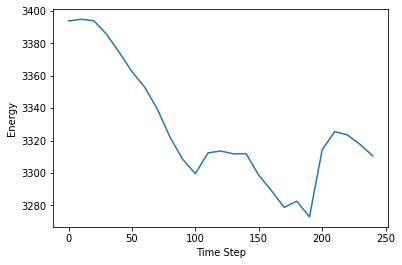

In [14]:
import matplotlib.pyplot as plt
import numpy as np 

sys_energy = tfcompute.outputs[0]
plt.plot(range(0, 250, 10), sys_energy)
plt.ylabel('Energy')
plt.xlabel('Time Step')
plt.show()